In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import glob
from keras import layers
from tensorflow import data as tf_data

In [29]:
import kagglehub

# Download the dataset
dataset_path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/skin-cancer9-classesisic


In [30]:
print("current directory contents: \n", os.listdir(dataset_path))

current directory contents: 
 ['Skin cancer ISIC The International Skin Imaging Collaboration', 'skin cancer isic the international skin imaging collaboration']


In [31]:
ISIC_folder = os.path.join(dataset_path, os.listdir(dataset_path)[1])
print(ISIC_folder)

/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration


In [32]:
print(os.listdir(ISIC_folder))

['Skin cancer ISIC The International Skin Imaging Collaboration']


In [33]:
ISIC_content_folder = os.path.join(ISIC_folder, os.listdir(ISIC_folder)[0])
print(ISIC_content_folder)

/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration


In [34]:
os.listdir(ISIC_content_folder)

['Test', 'Train']

In [35]:
train_image_folder = os.path.join(ISIC_content_folder, os.listdir(ISIC_content_folder)[1])
print(train_image_folder)
test_image_folder = os.path.join(ISIC_content_folder, os.listdir(ISIC_content_folder)[0])
print(test_image_folder)

/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train
/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [36]:
os.listdir(train_image_folder)

['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']

In [37]:
os.listdir(test_image_folder)

['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']

In [38]:
# os.listdir(os.path.join(train_image_folder, os.listdir(train_image_folder)[0]))

In [39]:
train_images_address = []
train_images_labels = []
test_images_address = []
test_images_labels = []

count = 0
for folder in os.listdir(train_image_folder):
    folder_path = os.path.join(train_image_folder, folder)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        train_images_address.append(file_path)
        train_images_labels.append(count)
    count = count + 1

count = 0
for folder in os.listdir(test_image_folder):
    folder_path = os.path.join(test_image_folder, folder)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        test_images_address.append(file_path)
        test_images_labels.append(count)
    count = count + 1

print("total classes in training folder: ", len(train_images_address))
print("total classes in test folder: ", len(test_images_address))
print("total training images: ",len(train_images_labels))
print("total test images", len(test_images_labels))



total classes in training folder:  2239
total classes in test folder:  118
total training images:  2239
total test images 118


In [40]:
class TFPreprocessingPipiline:
  def __init__(self, img_size = (224,224), batch_size = 32):
    self.img_size = img_size
    self.batch_size = batch_size

  def preprocess_image(self, image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels = 3)
    image = tf.reshape(image, [tf.shape(image)[0], tf.shape(image)[1], 3])
    image = tf.image.resize(image, self.img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

  def preprocess_with_augmentation(self, image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    image = tf.image.random_contrast(image, lower = 0.8, upper = 1.2)
    image = tf.image.random_contrast(image, lower = 0.8, upper = 1.2)


    k = tf.random.uniform([], 0, 4, tf.int32)
    image = tf.image.rot90(image, k)

    image = tf.clip_by_value(image, 0, 1)

    return image, label

  def create_dataset_from_directory(self, data_dir, validation_split = 0.2, subset = 'training', augment = True):
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = validation_split,
        subset = subset,
        seed = 42,
        image_size = self.img_size,
        batch_size = self.batch_size,
        label_mode = 'categorical'
    )

    if augment and subset == 'training':
      dataset = dataset.map(self.apply_augmentation_to_batch, num_paraller_calls = tf.data.AUTOTUNE)

    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

  def apply_augmentation_to_batch(self, images, labels):
    augmented_images = tf.map_fn(
        lambda img: self.augment_single_image(img),
        images,
        parallel_iterations = 10,
        dtype = tf.float32
    )
    return augmented_images, labels

  def augment_single_images(self, images):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image

  def create_dataset_from_paths_and_labels(self, image_paths, labels, augment = True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    dataset = dataset.map(self.preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)

    if augment :
      dataset = dataset.map(self.preprocess_with_augmentation, num_parallel_calls = tf.data.AUTOTUNE)
    else:
      dataset = dataset.map(self.preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)

    dataset = dataset.shuffle(buffer_size = 1000)
    dataset = dataset.batch(self.batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

  def create_dataset_for_prediction(self, image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(
        lambda path : self.preprocess_image_only(path),
        num_parallel_calls = tf.data.AUTOTUNE
        )

    dataset = dataset.batch(self.batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

  def preprocess_image_only(self, image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels = 3)
    image = tf.reshape(image, [tf.shape(image)[0], tf.shape(image)[1], 3])
    image = tf.image.resize(image, self.img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

  def visualize_batch(self, dataset, num_images = 9):
    import matplotlib.pyplot as plt

    for images in dataset.take(1):
      fig, ax = plt.subplots(3,3, figsize = (10,10))
      ax = ax.ravel()

      for i in range(min(num_images, len(images))):
        img = images[i].numpy()
        ax[i].imshow(img)
        ax[i].axis('off')

      plt.tight_layout()
      plt.show()
      break



In [41]:
# preprocessing_pipeline = PreprocessingTrainingData()
# training_dataset = preprocessing_pipeline.create_dataset(train_images_address, train_images_labels)
# test_dataset = preprocessing_pipeline.create_dataset_for_prediction(test_images_address)

In [42]:
# training_dataset.take(1)

In [43]:
# preprocessing_pipeline.visualize_batch(training_dataset)

In [44]:
pipeline = TFPreprocessingPipiline(img_size=(224, 224), batch_size = 32)

train_dataset = pipeline.create_dataset_from_paths_and_labels(train_images_address, train_images_labels)

print(f"dataset: {train_dataset}")

test_dataset = pipeline.create_dataset_for_prediction(test_images_address)

print(f"dataset: {test_dataset}")

train_dataset.take(1)

dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
dataset: <_PrefetchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>


<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

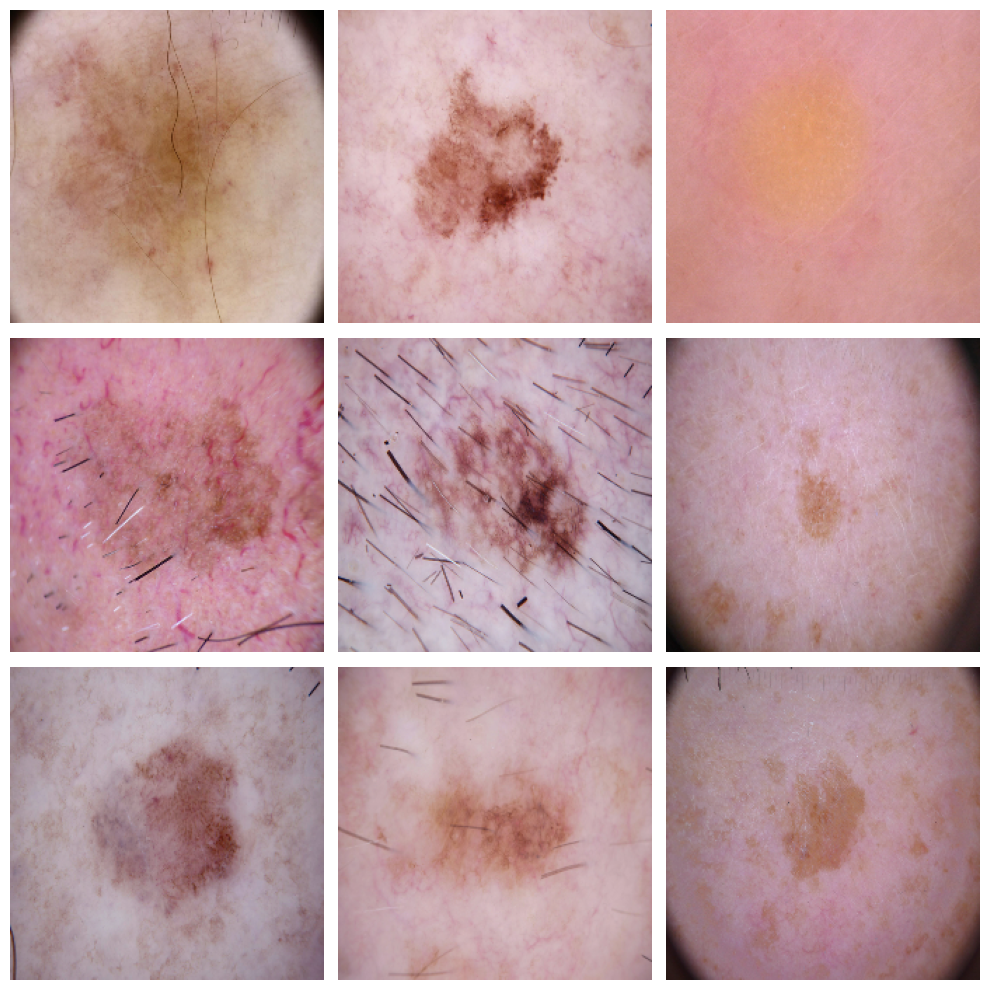

In [45]:
pipeline.visualize_batch(test_dataset)

### Building the VGG16 Architecture Model

In [46]:
def model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # Rescaling layer 
    x = keras.layers.Rescaling(scale=1.0 / 255.0)(inputs)
    
    # First conv block
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2
    )(x)
    
    # Second conv block
    x = keras.layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2
    )(x)
    
    # Third conv block
    x = keras.layers.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2
    )(x)
    
    # Fourth conv block
    x = keras.layers.Conv2D(
        filters=512,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=512,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=512,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2
    )(x)
    
    # Flatten before dense layers
    x = keras.layers.Flatten()(x)
    
    # Fully connected layers
    x = keras.layers.Dense(
        units=4096,
        activation="relu"
    )(x)
    x = keras.layers.Dropout(0.5)(x)  
    
    x = keras.layers.Dense(
        units=4096,
        activation="relu"
    )(x)
    x = keras.layers.Dropout(0.5)(x)  
    
    # Output layer
    outputs = keras.layers.Dense(
        units=num_classes,
        activation="softmax"
    )(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



In [47]:
print(len(os.listdir(train_image_folder)) )

9


In [48]:
model = model(input_shape=(224, 224, 3), num_classes=len(os.listdir(train_image_folder)))

In [49]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [50]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │     411,045,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 435,499,337 (1.62 GB)

 Trainable params: 435,499,337 (1.62 GB)

 Non-trainable params: 0 (0.00 B)

In [51]:
callbacks = [
        keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3
        )
    ]

In [ ]:
history = model.fit(
        x_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(test_dataset, test_images_label),
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")